### Emotion-Antecedent Appraisal Checks: EEG and EMG data sets for Novelty and Pleasantness 

This dataset is constructed by van Peer et al and it can be downloaded from https://zenodo.org/record/197404#.XZtCzy2B0UE. (van Peer, Jacobien M., Coutinho , Eduardo, Grandjean, Didier, & Scherer, Klaus R. (2017). Emotion-Antecedent Appraisal Checks: EEG and EMG datasets for Novelty and Pleasantness [Data set]. PloS One. Zenodo. http://doi.org/10.5281/zenodo.197404)

In [382]:
# For elimiating warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [383]:
import numpy as np
import mne
from mne.io import concatenate_raws, read_raw_fif
import mne.viz
from os import walk

Get the files that belongs to participant 9

In [384]:
files = []
path = '../../study1/study1_eeg/'
participant_prefix = 'P-09_'
for (dirpath, dirnames, filenames) in walk(path):
    new_names = [dirpath+f for f in filenames if (participant_prefix in f)]
    files.extend(new_names)
    break

Read the CSV file as a NumPy array

In [385]:
tmp = np.loadtxt(files[0], delimiter=',')
n_channels = tmp.shape[0]
n_times = tmp.shape[1]
participant_data = np.ndarray((len(files),n_channels,n_times))

for trial in range(0,len(files)):
    new_data = np.loadtxt(files[trial], delimiter=',')
    if trial == 0:
        print('n_channels, n_times: ' + str(new_data.shape))
    new_data = new_data.astype(float)
    participant_data[trial] = new_data

print('Number of epochs: ' + str(participant_data.shape))

n_channels, n_times: (64, 384)
Number of epochs: (380, 64, 384)


Extract event names from file names

In [386]:
epochs_events = []
for f in files:
    res = f.split('_')
    epochs_events.append(res[-2])

Events parameter of epochs object is a numpy ndarray which has dimensions as (n_epochs,3).
It has the following structure for each epoch: (event_sample, previous_event_id, event_id)

In [387]:
unique_events = list(set(epochs_events))
print(unique_events)
unique_events = sorted(unique_events)
print(unique_events)
unique_events_num = [i for i in range(len(unique_events))]
epoch_events_num = np.ndarray((len(epochs_events),3),int)

for i in range(len(epochs_events)):
    for j in range(len(unique_events)):
        if epochs_events[i] == unique_events[j]:
            epoch_events_num[i,2] = unique_events_num[j]
            if i >0:
                epoch_events_num[i,1] = epoch_events_num[i-1,2]
            else:
                epoch_events_num[i,1] = unique_events_num[j]
        epoch_events_num[i,0] = i
        
event_id = {}
for i in range(len(unique_events)):
    event_id[unique_events[i]] = unique_events_num[i]
print(event_id)

['NU', 'FN', 'FU', 'FP', 'NP', 'NN']
['FN', 'FP', 'FU', 'NN', 'NP', 'NU']
{'FN': 0, 'FP': 1, 'FU': 2, 'NN': 3, 'NP': 4, 'NU': 5}


Get the positions of channels. The data is collected with biosemi eeg device with 64 channels. Therefore biosemi64 should be passed to read_montage function to get channel positions.

Number of channels: 67


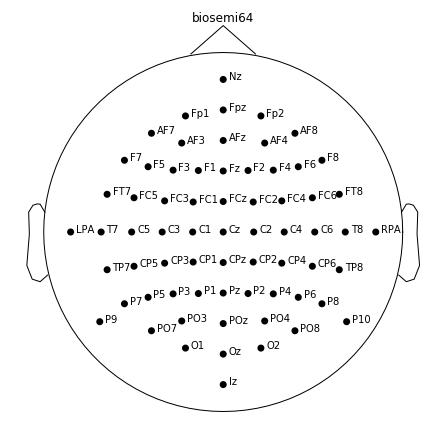

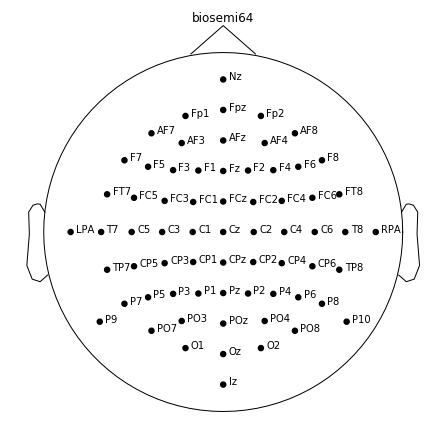

In [388]:
%matplotlib inline
montage = mne.channels.read_montage('biosemi64') 
print('Number of channels: ' + str(len(montage.ch_names)))
montage.plot(show_names=True)

Please note that montage has 64+3 channels however the data has 64 channels although data is collected with the same device. The additional 3 channels are fiducial points and they exist for referencing purposes. In order to match the data and motange, remove the fudicials. 

In [389]:
n_channels = 64
fiducials = ['Nz', 'LPA', 'RPA']
ch_names = montage.ch_names
ch_names = [x for x in ch_names if x not in fiducials]
print('Number of cahnnels after removing the fudicials: '+ str(len(ch_names)))
# Specify ampling rate
sfreq = 256  # Hz

Number of cahnnels after removing the fudicials: 64


Create the info structure for epochs object and then, create the epochs object with data of the participant, info object and the numpy array that keeps the events.

In [390]:
epochs_info = mne.create_info(ch_names, sfreq, ch_types='eeg')
epochs = mne.EpochsArray(data=participant_data, info=epochs_info, events=epoch_events_num, event_id=event_id)
epochs.set_montage(montage)
epochs.drop_bad()

380 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


Plot epochs, average of epochs and events.

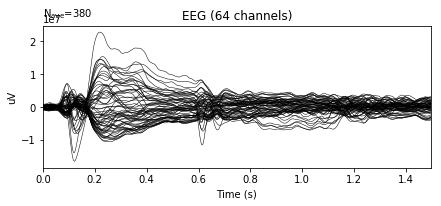

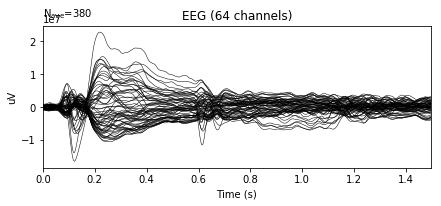

In [391]:
# Plot of averaged epochs
epochs.average().plot()

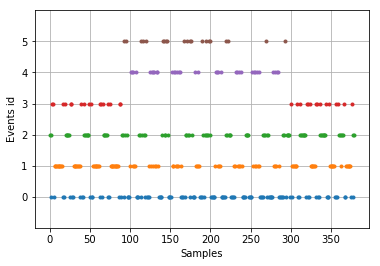

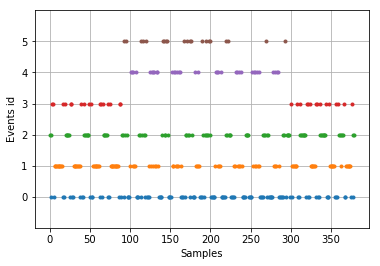

In [392]:
#plot events
mne.viz.plot_events(epochs.events)

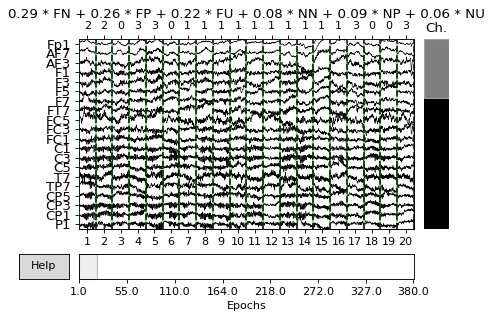

In [393]:
# Plot of epochs
%matplotlib tk
mne.viz.plot_epochs(epochs, scalings='auto')

Save the epochs to a file with .fif extention.

In [394]:
epochs.save('../../study1/study1_eeg/epochdata/'+participant_prefix[:-1]+'.fif', verbose='error')